In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
sns.set_theme()

In [3]:
# Initialize weight matrices and bias vectors
def initialize_weights(layers=(784, 60, 60, 10)):

    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):

        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])

        W.append(w_temp)
        B.append(b_temp)
    return W, B

In [4]:
# Define the sigmoid activation function, its derivative and mean squared error

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def mse(a, y):
    return 0.5*sum((a-y)**2)

In [ ]:
def load_kmnist_numpy():
    # Load KMNIST in supervised format
    train_ds, test_ds = tfds.load('kmnist', split=['train', 'test'], as_supervised=True)

    # Convert dataset to NumPy arrays
    def to_numpy(ds):
        images = []
        labels = []
        for image, label in tfds.as_numpy(ds):
            image = image.astype(np.float32) / 255.0  # Normalize
            image = np.squeeze(image)  # Shape: (28, 28)
            images.append(image)
            labels.append(label)
        return np.array(images), np.array(labels)

    X_train, y_train = to_numpy(train_ds)
    X_test, y_test = to_numpy(test_ds)

    return X_train, y_train, X_test, y_test

# Example usage
X_train, y_train, X_test, y_test = load_kmnist_numpy()
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

In [65]:
# Mapping each of the ten japanese characters to digits 0-10
""""
0: お
1: き
2: す
3: つ
4: な
5: は
6: ま
7: や
8: れ
9: を
"""
hiragana_mapping = {
    0: 'お',
    1: 'き',
    2: 'す',
    3: 'つ',
    4: 'な',
    5: 'は',
    6: 'ま',
    7: 'や',
    8: 'れ',
    9: 'を'
}

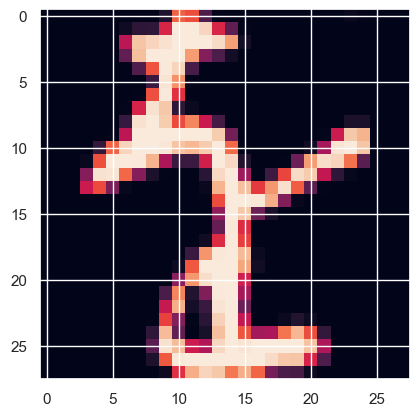

Character: を


In [66]:
plt.imshow(X_train[0])
plt.show()
print("Character: " + str(hiragana_mapping[y_train[0]]))

In [ ]:
# Flatten the training images into column vectors.
flat_train_X = []
# One hot encode the training labels
onehot_train_y = []

for x, y in zip(X_train, y_train):
    flat_train_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    onehot_train_y.append(temp_vec)


# Do the same for the testing data
flat_test_X = []
onehot_test_y = []

for x, y in zip(X_test, y_test):
    flat_test_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y] = 1.0
    onehot_test_y.append(temp_vec)


In [118]:
# Initialize weights
W, B = initialize_weights()

def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)

        a = sigmoid(z)
        A.append(a)

    if not predict_vector:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

In [45]:
def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")


def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

In [125]:
class DenseNetwork:
    def __init__(self, layers=(784, 60, 60, 10)):
        self.layers = layers
        self.W, self.B = initialize_weights(layers)
        self.errors = []

    def train(self, X_train, y_train, alpha=0.05, epochs=10):
        # Print the initial mean squared error
        self.errors = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent.
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error
                output_error = (A[L] - yi)*sigmoid_prime(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function
                # is non-inclusive.
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*sigmoid_prime(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient
                # descent.
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors.append(MSE(self.W, self.B, X_train, y_train))
            print(f"{k + 1}-Epoch Cost = {self.errors[-1]}")


    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

In [ ]:
net = DenseNetwork()
# MSE pre-training
print(f"MSE(net.W, net.B, flat_train_X, onehot_train_y) = {MSE(net.W, net.B, flat_train_X, onehot_train_y)} \n")
net.train(flat_train_X, onehot_train_y, alpha=0.05, epochs=100)

In [ ]:
# Visualize the mean squared error over the training process
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors))
plt.plot(epochs, net.errors, marker = "o")
plt.xticks(epochs[::10])
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

In [ ]:
# Example prediction
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted character is: {hiragana_mapping[prediction]}")
print(f"actual character is: {hiragana_mapping[np.argmax(onehot_test_y[i])]}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

In [ ]:
# Example prediction
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted character is: {hiragana_mapping[prediction]}")
print(f"actual character is: {hiragana_mapping[np.argmax(onehot_test_y[i])]}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

Note that this character is the same as the one above it, but is drastically different looking.

In [87]:
# Get accuracy over all 10,000 test instances

incorrect_predictions = 0
for i in range(len(flat_test_X)):
    prediction = net.predict(flat_test_X[i])
    if prediction != np.argmax(onehot_test_y[i]): incorrect_predictions += 1

print(f"Incorrect predictions: {incorrect_predictions}")
print(f"Classification Accuracy: {(10000 - incorrect_predictions)/10000}")

Incorrect predictions: 1447
Classification Accuracy: 0.8553


In [117]:
# Experiment with other network architectures

net2 = DenseNetwork(layers=(784, 150, 150, 10))
net3 = DenseNetwork(layers=(784, 200, 80, 10))
net4 = DenseNetwork(layers=(784, 50, 30, 10))
net5 = DenseNetwork(layers=(784, 40, 40, 40, 10))
print(len(net5.B))

5


In [129]:
# Train network with 150 neurons per hidden layer

net2.train(flat_train_X, onehot_train_y, alpha=0.05, epochs=100)

Starting Cost = [1.28233803]
1-Epoch Cost = [0.1123868]
2-Epoch Cost = [0.07789027]
3-Epoch Cost = [0.06180685]
4-Epoch Cost = [0.0508069]
5-Epoch Cost = [0.04218064]
6-Epoch Cost = [0.03481296]
7-Epoch Cost = [0.03027216]
8-Epoch Cost = [0.02757797]
9-Epoch Cost = [0.02456634]
10-Epoch Cost = [0.02153433]
11-Epoch Cost = [0.01969899]
12-Epoch Cost = [0.01802901]
13-Epoch Cost = [0.01676226]
14-Epoch Cost = [0.01565154]
15-Epoch Cost = [0.0146347]
16-Epoch Cost = [0.01380663]
17-Epoch Cost = [0.0125669]
18-Epoch Cost = [0.01154784]
19-Epoch Cost = [0.0107455]
20-Epoch Cost = [0.01005847]
21-Epoch Cost = [0.00951585]
22-Epoch Cost = [0.00906456]
23-Epoch Cost = [0.00877126]
24-Epoch Cost = [0.00818432]
25-Epoch Cost = [0.00799328]
26-Epoch Cost = [0.00775002]
27-Epoch Cost = [0.00738715]
28-Epoch Cost = [0.00711741]
29-Epoch Cost = [0.00687577]
30-Epoch Cost = [0.0066141]
31-Epoch Cost = [0.00656828]
32-Epoch Cost = [0.00631618]
33-Epoch Cost = [0.00617905]
34-Epoch Cost = [0.00601947]


In [131]:
# Train network with 200 and 80 neurons per hidden layer

net3.train(flat_train_X, onehot_train_y, alpha=0.05, epochs=100)

Starting Cost = [1.42509869]
1-Epoch Cost = [0.11175647]
2-Epoch Cost = [0.07679256]
3-Epoch Cost = [0.06061729]
4-Epoch Cost = [0.04893243]
5-Epoch Cost = [0.03997349]
6-Epoch Cost = [0.03364308]
7-Epoch Cost = [0.02902415]
8-Epoch Cost = [0.02546805]
9-Epoch Cost = [0.02277421]
10-Epoch Cost = [0.02057884]
11-Epoch Cost = [0.01844811]
12-Epoch Cost = [0.01676314]
13-Epoch Cost = [0.01615556]
14-Epoch Cost = [0.01487646]
15-Epoch Cost = [0.01286772]
16-Epoch Cost = [0.01171776]
17-Epoch Cost = [0.01067881]
18-Epoch Cost = [0.01000871]
19-Epoch Cost = [0.00964509]
20-Epoch Cost = [0.00939397]
21-Epoch Cost = [0.00850274]
22-Epoch Cost = [0.00803835]
23-Epoch Cost = [0.00748769]
24-Epoch Cost = [0.00700959]
25-Epoch Cost = [0.00672018]
26-Epoch Cost = [0.00629006]
27-Epoch Cost = [0.00588358]
28-Epoch Cost = [0.00567783]
29-Epoch Cost = [0.00537124]
30-Epoch Cost = [0.00519018]
31-Epoch Cost = [0.00507072]
32-Epoch Cost = [0.00491747]
33-Epoch Cost = [0.00477296]
34-Epoch Cost = [0.0046

In [133]:
# Train network with 50 and 30 neurons per hidden layer

net4.train(flat_train_X, onehot_train_y, alpha=0.05, epochs=100)

Starting Cost = [1.41254593]
1-Epoch Cost = [0.10521409]
2-Epoch Cost = [0.07337457]
3-Epoch Cost = [0.06005367]
4-Epoch Cost = [0.05321695]
5-Epoch Cost = [0.04831384]
6-Epoch Cost = [0.04439007]
7-Epoch Cost = [0.04138753]
8-Epoch Cost = [0.03911253]
9-Epoch Cost = [0.03726901]
10-Epoch Cost = [0.0355193]
11-Epoch Cost = [0.034002]
12-Epoch Cost = [0.03282732]
13-Epoch Cost = [0.03163716]
14-Epoch Cost = [0.03074068]
15-Epoch Cost = [0.03019148]
16-Epoch Cost = [0.02975717]
17-Epoch Cost = [0.02916786]
18-Epoch Cost = [0.02821784]
19-Epoch Cost = [0.02737266]
20-Epoch Cost = [0.02657326]
21-Epoch Cost = [0.02576058]
22-Epoch Cost = [0.02522432]
23-Epoch Cost = [0.02440259]
24-Epoch Cost = [0.02346646]
25-Epoch Cost = [0.02313561]
26-Epoch Cost = [0.02247932]
27-Epoch Cost = [0.02189705]
28-Epoch Cost = [0.02180259]
29-Epoch Cost = [0.0209316]
30-Epoch Cost = [0.02072695]
31-Epoch Cost = [0.02076406]
32-Epoch Cost = [0.01981665]
33-Epoch Cost = [0.01978463]
34-Epoch Cost = [0.01907146

In [121]:
# Train network with 3 hidden layers, each with 40 neurons

net5.train(flat_train_X, onehot_train_y, alpha=0.01, epochs=100)

Starting Cost = [0.03525019]
1-Epoch Cost = [0.03067678]
2-Epoch Cost = [0.02951348]
3-Epoch Cost = [0.02881298]
4-Epoch Cost = [0.02821254]
5-Epoch Cost = [0.0277073]
6-Epoch Cost = [0.02726634]
7-Epoch Cost = [0.02688086]
8-Epoch Cost = [0.02652622]
9-Epoch Cost = [0.02618427]
10-Epoch Cost = [0.02585332]
11-Epoch Cost = [0.0255279]
12-Epoch Cost = [0.02520677]
13-Epoch Cost = [0.02489886]
14-Epoch Cost = [0.02461104]
15-Epoch Cost = [0.02435306]
16-Epoch Cost = [0.02411552]
17-Epoch Cost = [0.02389631]
18-Epoch Cost = [0.02369039]
19-Epoch Cost = [0.02349493]
20-Epoch Cost = [0.02328056]
21-Epoch Cost = [0.02302869]
22-Epoch Cost = [0.02280956]
23-Epoch Cost = [0.02268491]
24-Epoch Cost = [0.02258431]
25-Epoch Cost = [0.02242235]
26-Epoch Cost = [0.02223978]
27-Epoch Cost = [0.02201442]
28-Epoch Cost = [0.02176793]
29-Epoch Cost = [0.02154439]
30-Epoch Cost = [0.02133884]
31-Epoch Cost = [0.02114612]
32-Epoch Cost = [0.02096422]
33-Epoch Cost = [0.02079712]
34-Epoch Cost = [0.020646

In [134]:
# Get accuracy over all 10,000 test instances for alternate architectures

incorrect_predictions_net2 = 0
incorrect_predictions_net3 = 0
incorrect_predictions_net4 = 0
incorrect_predictions_net5 = 0
for i in range(len(flat_test_X)):
    prediction_net2 = net2.predict(flat_test_X[i])
    if prediction_net2 != np.argmax(onehot_test_y[i]): incorrect_predictions_net2 += 1
    prediction_net3 = net3.predict(flat_test_X[i])
    if prediction_net3 != np.argmax(onehot_test_y[i]): incorrect_predictions_net3 += 1
    prediction_net4 = net4.predict(flat_test_X[i])
    if prediction_net4 != np.argmax(onehot_test_y[i]): incorrect_predictions_net4 += 1
    prediction_net5 = net5.predict(flat_test_X[i])
    if prediction_net5 != np.argmax(onehot_test_y[i]): incorrect_predictions_net5 += 1

print(f"Network 1 Classification Accuracy: {(10000 - incorrect_predictions)/10000}")
print(f"Network 2 Classification Accuracy: {(10000 - incorrect_predictions_net2)/10000}")
print(f"Network 3 Classification Accuracy: {(10000 - incorrect_predictions_net3)/10000}")
print(f"Network 4 Classification Accuracy: {(10000 - incorrect_predictions_net4)/10000}")
print(f"Network 5 Classification Accuracy: {(10000 - incorrect_predictions_net5)/10000}")

Network 1 Classification Accuracy: 0.8553
Network 2 Classification Accuracy: 0.8951
Network 3 Classification Accuracy: 0.9067
Network 4 Classification Accuracy: 0.8395
Network 5 Classification Accuracy: 0.8194


Conclusion:
With the neural network architecture of two hidden layers, having 60 neurons each, the model is able to correctly classify the Japanese handwritten characters about 85.5% of the time. This is after 100 epochs of training, which took about 15 minutes to run. This is a relatively good result, considering the wide variety of ways that the same character is drawn, and the low 28x28 pixel resolution. I tested 4 additional network architectures, with hidden layers schemes of (150, 150), (200, 80), (50, 30), and (40, 40, 40). All of these ran for 100 epochs and 0.05 learning rate, except for the (40, 40, 40) one, which needed a smaller step size, so I used 0.01. The two things to note are the classification accuracy and the runtime. the architecture of (200, 80) had the highest accuracy, but took 35 minutes to complete 100 epochs of training. Similarly, the (150, 150) structure took 30 minutes and had almost as good of an accuracy. The (50, 30) and the (40, 40, 40) structures were less accurate than the (60, 60) model, and ran for similar amounts of time. With 784 features, it seems that it is more accurate to use as many nodes as possible, and likely no more than two layers is useful in this case. At some point, increasing the number of neurons may begin to overfit the training data, resulting in decreased accuracy on the testing set despite a very low MSE on the training set. However, that point was not yet reached in this case. Additionally, each structure may do better with a more fine-tuned learning rate.